# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=f12164de721884ae50fef65768101476fdc7e8a12c1cf7a1585d80ca2ca9c41e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a8a3ac608d0b70e302b605f00b686f76555bad8196e81de2515d0582a8e6de21
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 40.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


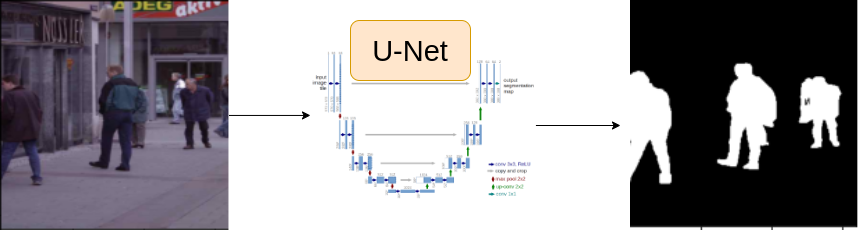

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
Data_dir = '/content/'

Device = 'cuda'
Epochs = 25
L_Rate = 0.003
Image_size = 256
Batch_size = 16

Encoder  = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
#read csv files
df =  pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
#select an image
row  = df.iloc[21]

#extract the image path and mask path
image_path =row.images
mask_path =  row.masks

# read image
image = cv2.imread(image_path)

# convert in to bgR format
image =  cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

#read mask and reduction
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0


In [ ]:
#split the data set
train_set , valid_set =  train_test_split (df , test_size= 0.2, random_state= 42)


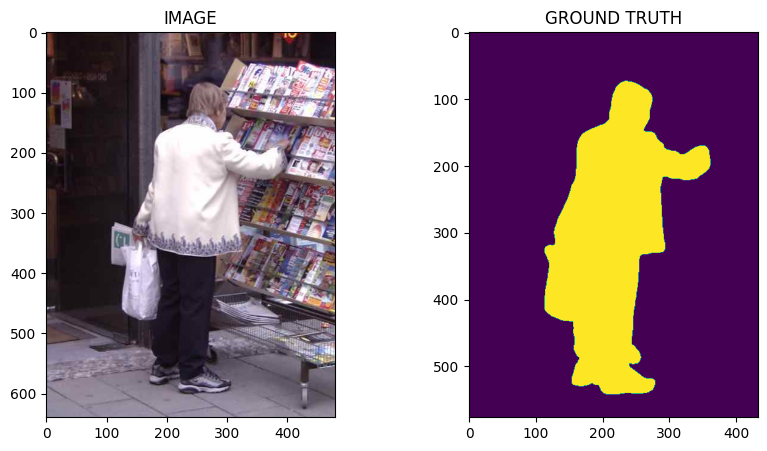

In [ ]:
#visualization

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)#,cmap = 'gray')

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
    """
    Function to define the augmentation pipeline for training images.

    Returns:
        A.Compose: A composition of augmentations to be applied to training images and masks.
    """
    return A.Compose([
        A.Resize(Image_size, Image_size),  # Resize images and masks to the specified size (Image_size x Image_size)
        A.HorizontalFlip(p=0.5),  # Randomly flip images and masks horizontally with a probability of 50%
        A.VerticalFlip(p=0.5)  # Randomly flip images and masks vertically with a probability of 50%
    ], is_check_shapes=False)  # Disable shape checking to allow for different input sizes

def get_valid_augs():
    """
    Function to define the augmentation pipeline for validation images.

    Returns:
        A.Compose: A composition of augmentations to be applied to validation images and masks.
    """
    return A.Compose([
        A.Resize(Image_size, Image_size)  # Resize validation images and masks to the specified size
    ], is_check_shapes=False)  # Disable shape checking to accommodate any input size differences


# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:

class SegmentationDataset(Dataset):
    """
    Custom Dataset class for loading images and their corresponding masks for
    semantic segmentation tasks. Inherits from PyTorch's Dataset class.
    """

    def __init__(self, df, augmentations):
        """
        Constructor method for initializing the dataset.

        Args:
        - df: Pandas DataFrame containing paths to images and masks.
        - augmentations: Albumentations transformation pipeline for data augmentation.
        """
        self.df = df  # DataFrame with image and mask paths
        self.augmentations = augmentations  # Augmentation pipeline to apply on data

    def __len__(self):
        """
        Method to get the number of samples in the dataset.

        Returns:
        - Integer: The total number of samples (images) in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Method to get a single sample (image and mask) from the dataset.

        Args:
        - idx: Index of the sample in the DataFrame.

        Returns:
        - image: Preprocessed image as a PyTorch tensor (shape: (c, h, w)).
        - mask: Corresponding mask as a PyTorch tensor (shape: (1, h, w)).
        """
        # Get the row corresponding to the given index
        row = self.df.iloc[idx]

        # Extract the file paths for the image and its corresponding mask
        image_path = row.images
        mask_path = row.masks

        # Read the image using OpenCV and convert it from BGR to RGB format
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the mask in grayscale (single channel) mode
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Add a new axis to the mask to make its shape (h, w, 1)
        mask = np.expand_dims(mask, axis=-1)

        # If augmentations are provided, apply them to both the image and the mask
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # Transpose the image and mask from (h, w, c) to (c, h, w)
        # This is required to match the expected format for PyTorch (channels-first)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # Convert to float32
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)    # Convert to float32

        # Convert the image and mask to PyTorch tensors and normalize them
        image = torch.Tensor(image) / 255.0  # Normalize the image to [0, 1]
        mask = torch.round(torch.Tensor(mask) / 255.0)  # Normalize and round the mask to [0, 1]

        # Return the processed image and mask
        return image, mask


In [ ]:
trainset = SegmentationDataset(train_set, get_train_augs())
validset = SegmentationDataset(valid_set, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


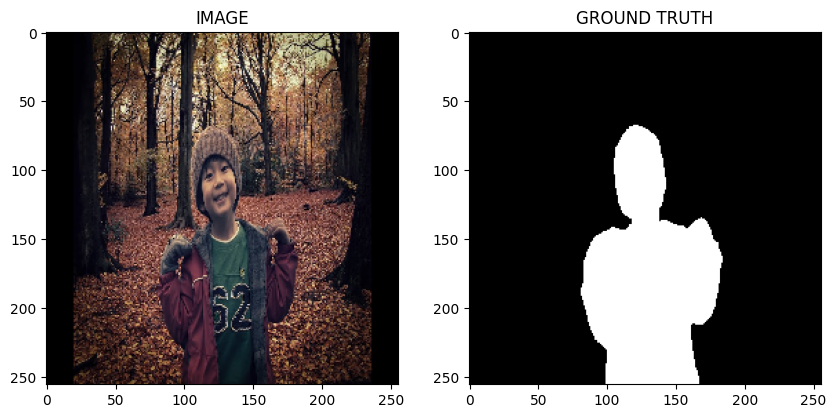

In [ ]:
idx = 21

image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader =  DataLoader(trainset, batch_size = Batch_size, shuffle = True)
validloader = DataLoader (validset, batch_size = Batch_size)

In [ ]:
print(f'total no. of trainloader :  {len (trainloader)}')
print (f'total no. of valid loader : {len (validloader)}')


total no. of trainloader :  15
total no. of valid loader : 4


In [ ]:
for image, mask  in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print (f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 256, 256])
One batch mask shape : torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=Encoder,  # Encoder model name (e.g., 'resnet34')
            encoder_weights=weights,  # Pretrained weights (e.g., 'imagenet')
            in_channels=3,  # Number of input channels (e.g., RGB images)
            classes=1,  # Number of output classes (binary segmentation in this case)
            activation=None  # No activation function at the end
        )

    # Define forward method
    def forward(self, images, masks=None):
        logits = self.arc(images)  # Forward pass through the Unet model

        if masks is not None:
            # Calculate the DiceLoss and BCEWithLogitsLoss if masks are provided
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2  # Return logits and combined loss

        return logits  # Return only the logits when masks are not provided

In [ ]:
Model  = SegmentationModel()
Model.to(Device);

# Task 7 : Create Train and Validation Function

In [ ]:
from tqdm import tqdm  # Importing tqdm for progress bar visualization

def train_fn(data_loader, model, optimizer):
    """
    Training function to perform one epoch of training.

    Args:
    - data_loader: DataLoader providing batches of images and masks for training.
    - model: The segmentation model to be trained.
    - optimizer: The optimizer responsible for updating model weights.

    Returns:
    - Average loss over the entire dataset for this epoch.
    """
    model.train()  # Set the model to training mode (enables gradient computation)
    total_loss = 0.0  # Variable to accumulate the total loss over the epoch

    # Iterate over all batches in the data loader
    for images, masks in tqdm(data_loader):
        # Move images and masks to the appropriate device (GPU/CPU)
        images = images.to(Device)
        masks = masks.to(Device)

        # Zero the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Get the model's predictions (logits) and calculate the loss
        logits, loss = model(images, masks)

        # Backward pass: Compute gradients of the loss w.r.t model parameters
        loss.backward()

        # Optimizer step: Update the model parameters based on the computed gradients
        optimizer.step()

        # Accumulate the loss for this batch
        total_loss += loss.item()

    # Return the average loss over all batches in the data loader
    return total_loss / len(data_loader)


In [ ]:

def eval_fn(data_loader, model):
    """
    Evaluation function to perform validation or testing.

    Args:
    - data_loader: DataLoader providing batches of images and masks for evaluation.
    - model: The segmentation model to be evaluated.

    Returns:
    - Average loss over the entire dataset for the evaluation phase.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    total_loss = 0.0  # Variable to accumulate the total loss during evaluation

    # Disable gradient computation (no need for backward pass during evaluation)
    with torch.no_grad():
        # Iterate over all batches in the data loader
        for images, masks in tqdm(data_loader):
            # Move images and masks to the appropriate device (GPU/CPU)
            images = images.to(Device)
            masks = masks.to(Device)

            # Forward pass: Get the model's predictions (logits) and calculate the loss
            logits, loss = model(images, masks)

            # Accumulate the loss for this batch
            total_loss += loss.item()

    # Return the average loss over all batches in the data loader
    return total_loss / len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer =  torch.optim.Adam(Model.parameters(), lr = L_Rate)

In [ ]:

# Initialize best_valid_loss with infinity
best_valid_loss = np.Inf

# Loop through the specified number of epochs
for i in range(Epochs):
    # Perform training on the training set
    train_loss = train_fn(trainloader, Model, optimizer)  # Use 'model' instead of 'Model'

    # Perform evaluation on the validation set
    valid_loss = eval_fn(validloader, Model)  # Use 'model' instead of 'Model'

    # Check if the current validation loss is lower than the best loss seen so far
    if valid_loss < best_valid_loss:
        # Save the model's state if the validation loss improves
        torch.save(Model.state_dict(), 'best_model.pt')
        print('SAVED MODEL')
        best_valid_loss = valid_loss  # Update the best validation loss

    # Print the loss for the current epoch
    print(f'Epoch: {i+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


SAVED MODEL
Epoch: 1, Train Loss: 0.1182, Valid Loss: 0.1964


100%|██████████| 4/4 [00:00<00:00,  7.68it/s]


Epoch: 2, Train Loss: 0.1333, Valid Loss: 0.2017


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


SAVED MODEL
Epoch: 3, Train Loss: 0.1107, Valid Loss: 0.1933


100%|██████████| 4/4 [00:00<00:00,  7.62it/s]


Epoch: 4, Train Loss: 0.1006, Valid Loss: 0.2055


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


SAVED MODEL
Epoch: 5, Train Loss: 0.0884, Valid Loss: 0.1914


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Epoch: 6, Train Loss: 0.0816, Valid Loss: 0.2034


100%|██████████| 4/4 [00:00<00:00,  7.47it/s]


SAVED MODEL
Epoch: 7, Train Loss: 0.0836, Valid Loss: 0.1663


100%|██████████| 4/4 [00:00<00:00,  7.56it/s]


Epoch: 8, Train Loss: 0.0772, Valid Loss: 0.2100


100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


Epoch: 9, Train Loss: 0.0815, Valid Loss: 0.2102


100%|██████████| 4/4 [00:00<00:00,  7.54it/s]


Epoch: 10, Train Loss: 0.0767, Valid Loss: 0.2163


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch: 11, Train Loss: 0.0818, Valid Loss: 0.2366


100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Epoch: 12, Train Loss: 0.0816, Valid Loss: 0.1956


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Epoch: 13, Train Loss: 0.0773, Valid Loss: 0.1916


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


Epoch: 14, Train Loss: 0.0882, Valid Loss: 0.1944


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch: 15, Train Loss: 0.0778, Valid Loss: 0.2086


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


Epoch: 16, Train Loss: 0.0742, Valid Loss: 0.1826


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


Epoch: 17, Train Loss: 0.0708, Valid Loss: 0.1974


100%|██████████| 4/4 [00:00<00:00,  8.17it/s]


Epoch: 18, Train Loss: 0.0705, Valid Loss: 0.1992


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Epoch: 19, Train Loss: 0.0699, Valid Loss: 0.2352


100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


Epoch: 20, Train Loss: 0.0731, Valid Loss: 0.1955


100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


Epoch: 21, Train Loss: 0.0762, Valid Loss: 0.1747


100%|██████████| 4/4 [00:00<00:00,  7.78it/s]


SAVED MODEL
Epoch: 22, Train Loss: 0.0709, Valid Loss: 0.1648


100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Epoch: 23, Train Loss: 0.0723, Valid Loss: 0.1972


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Epoch: 24, Train Loss: 0.0715, Valid Loss: 0.2326


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]

Epoch: 25, Train Loss: 0.0865, Valid Loss: 0.2291


# Task 9 : Inference

In [ ]:

def show_image(image, mask, pred_mask):
    """
    Function to display the input image, ground truth mask, and predicted mask.

    Args:
    - image: The original image to display (shape: (c, h, w)).
    - mask: The ground truth mask (shape: (1, h, w)).
    - pred_mask: The predicted mask (shape: (1, h, w)).
    """
    # Convert the image from (C, H, W) to (H, W, C) for visualization
    image = image.permute(1, 2, 0).numpy()  # Convert to numpy array
    image = (image - image.min()) / (image.max() - image.min())  # Normalize for display

    # Squeeze the mask and predicted mask to remove channel dimension
    mask = mask.squeeze(0).cpu().numpy()  # Shape: (H, W)
    pred_mask = pred_mask.squeeze(0).cpu().numpy()  # Shape: (H, W)

    # Create subplots for visualization
    plt.figure(figsize=(12, 4))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()  # Show the plots


<ipython-input-98-d31306f8542d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model.load_state_dict(torch.load('/content/best_model.pt'))


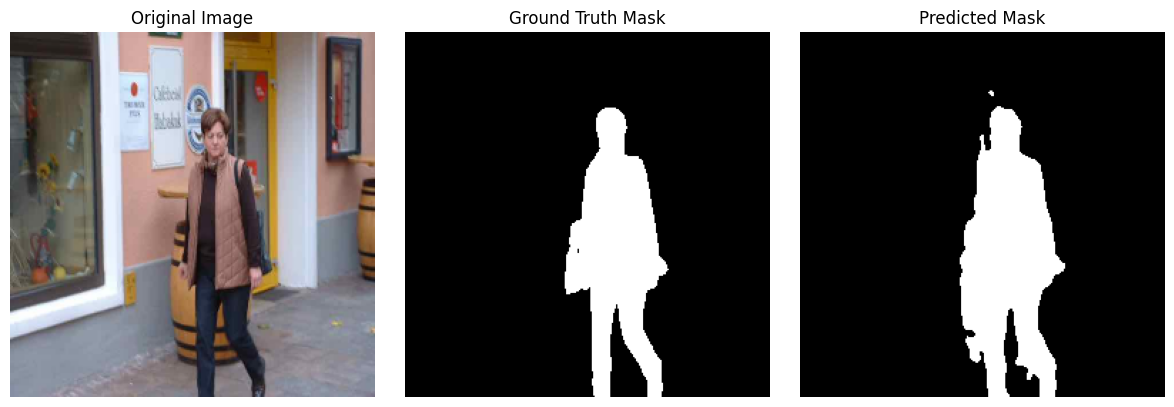

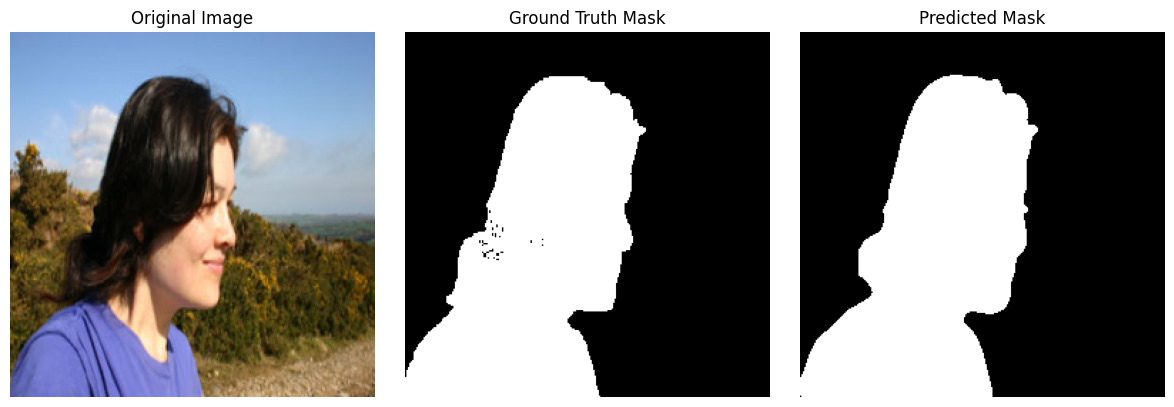

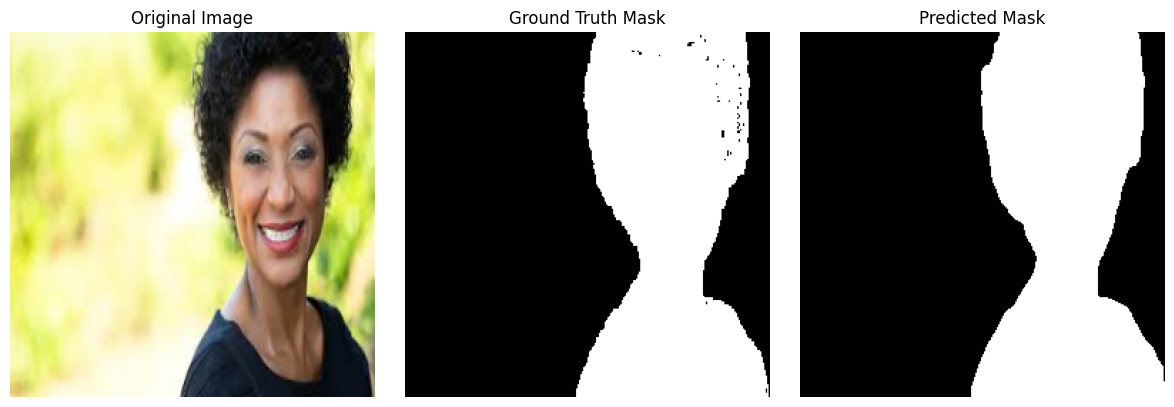

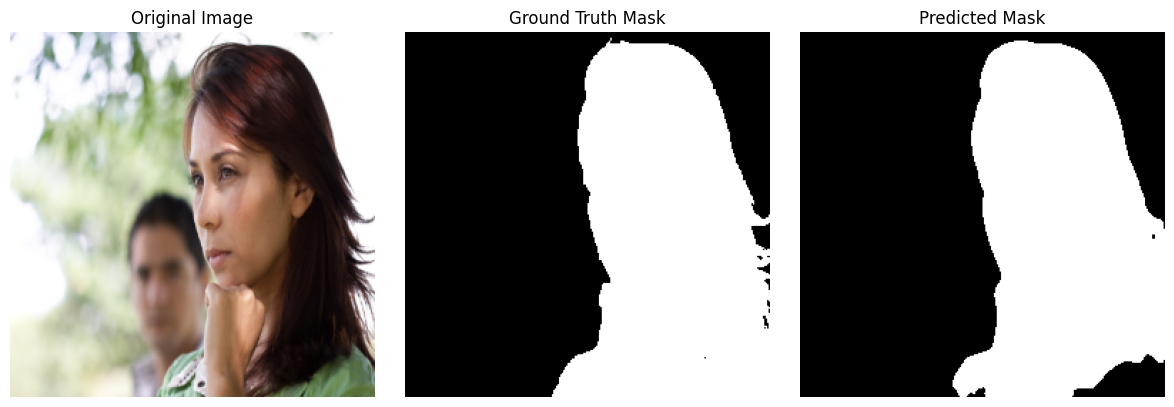

In [ ]:
# Set the index of the sample to visualize or evaluate
  #idx = 21

for idx in range (4):

  # Load the best model weights saved during training
  Model.load_state_dict(torch.load('/content/best_model.pt'))

  # Retrieve the image and corresponding mask from the validation dataset using the specified index
  image, mask = validset[idx]

  # Perform inference using the model on the input image
  # Add an extra dimension using unsqueeze(0) to simulate a batch size of 1
  logits_mask = Model(image.to(Device).unsqueeze(0))

  # Apply the sigmoid activation function to the model's output to get predicted probabilities
  pred_mask = torch.sigmoid(logits_mask)

  # Convert probabilities to binary mask: any value greater than 0.5 is classified as 1 (foreground)
  # and any value less than or equal to 0.5 is classified as 0 (background)
  pred_mask = (pred_mask > 0.5) * 1.0  # Convert probabilities to binary values (0 or 1)

  show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [ ]:
#helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))